In [1]:
import numpy as np
import simulation

# Simulation parameters
N = 5  # Number of particles
timesteps = 20000  # Number of simulation time steps
dt = 1e-2  # Timestep
alpha = 0.1  # cubic coupling
beta = 0.1  # quartic coupling

qs, _ = simulation.integration(N, timesteps, dt, alpha, beta)

# Import simulation
# qs = np.load("D:\School\Magistrska\data\\" + "_" + str(N) + "_" + str(timesteps) + "_" + str(dt) + "_" + str(alpha) + "_" + str(beta) + ".npy")

In [2]:
t = np.arange(0, timesteps)
t_sin = np.sin(t* 2 * np.pi / 400)

In [3]:
qs_mean = np.mean(qs)
qs_std = np.std(qs)

def preprocess(X):
  X = (X - qs_mean) / qs_std
  return X

def postprocess(X):
  X = X * qs_std + qs_mean
  return X

In [4]:
preprocess(qs)

array([[-3.57457490e-14,  2.24605087e+00, -3.54706871e-14,
        -2.24605087e+00, -3.62958728e-14],
       [-3.57457490e-14,  2.24580387e+00, -3.54707146e-14,
        -2.24580387e+00, -3.62958728e-14],
       [-3.57457490e-14,  2.24506272e+00, -3.54707970e-14,
        -2.24506272e+00, -3.62958728e-14],
       ...,
       [-3.57457490e-14, -1.25908036e+00, -4.72463075e-12,
         1.25908036e+00, -3.62958728e-14],
       [-3.57457490e-14, -1.23199394e+00, -4.68641451e-12,
         1.23199394e+00, -3.62958728e-14],
       [-3.57457490e-14, -1.20465364e+00, -4.64759855e-12,
         1.20465364e+00, -3.62958728e-14]])

In [5]:
qs = np.concatenate((t_sin[:, np.newaxis], qs), axis=1)

In [6]:
def qs_to_X_y(data, window_size=5):
  X = []
  y = []
  
  for i in range(len(data) - window_size):
    X.append(data[i: i + window_size])
    y.append(data[i + window_size])
    
  return np.array(X), np.array(y)

In [7]:
window_size = 100
X, y = qs_to_X_y(qs, window_size)

In [8]:
train_size = 0.7
val_size = 0.2
test_size = 0.1

tr=int(timesteps*train_size)
va=int(timesteps*val_size)
te=int(timesteps*test_size)

X_train, y_train = X[:tr], y[:tr]
X_val, y_val = X[-va:], y[-va:]
X_test, y_test = X[tr: tr +  te], y[tr: tr + te]

# LSTM

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
tf.keras.backend.set_floatx('float64')

model_lstm = Sequential()
model_lstm.add(InputLayer((window_size, N + 1)))
# model_lstm.add(LSTM(64, return_sequences=True, activation= "tanh"))
model_lstm.add(LSTM(30, activation="tanh"))
# model_lstm.add(Dense(8, 'relu'))
model_lstm.add(Dense(N + 1, activation='linear'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30)                4440      
_________________________________________________________________
dense (Dense)                (None, 6)                 186       
Total params: 4,626
Trainable params: 4,626
Non-trainable params: 0
_________________________________________________________________


In [10]:
cp = ModelCheckpoint('model_lstm/', save_best_only=True)
model_lstm.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [11]:
epochs = 10
batchsize = 32

model_lstm.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batchsize, callbacks=[cp], verbose = 2, workers=-2, use_multiprocessing=True)

Epoch 1/10
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model_lstm\assets
438/438 - 20s - loss: 0.0020 - root_mean_squared_error: 0.0450 - val_loss: 3.6990e-05 - val_root_mean_squared_error: 0.0061
Epoch 2/10
INFO:tensorflow:Assets written to: model_lstm\assets
438/438 - 22s - loss: 1.4755e-05 - root_mean_squared_error: 0.0038 - val_loss: 2.0666e-05 - val_root_mean_squared_error: 0.0045
Epoch 3/10
INFO:tensorflow:Assets written to: model_lstm\assets
438/438 - 21s - loss: 2.7687e-05 - root_mean_squared_error: 0.0053 - val_loss: 1.3558e-05 - val_root_mean_squared_error: 0.0037
Epoch 4/10
INFO:tensorflow:Assets written to: model_lstm\assets
438/438 - 21s - loss: 1.7775e-05 - root_mean_squared_error: 0.0042 - val_loss: 3.6965e-06 - val_root_mean_squared_error: 0.0019
Ep

In [12]:
test_pred_lstm = np.copy(X_test[0])

for k in range(len(y_test)-window_size):
    pred = model_lstm.predict(test_pred_lstm[np.newaxis, -window_size:])
    test_pred_lstm = np.concatenate((test_pred_lstm, pred), axis = 0)
    
test_pred_lstm[:, 1:] = postprocess(test_pred_lstm[:, 1:])

In [13]:
qs[:, 1:] = postprocess(qs[:, 1:])

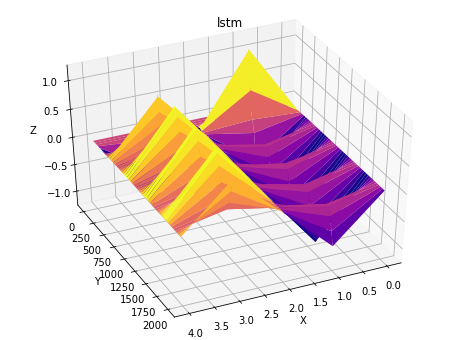

In [14]:
import matplotlib.pyplot as plt

%matplotlib inline

# Create the data for the 3D plot
x = np.arange(N)
y = np.arange(te)
x, y = np.meshgrid(x, y)
z = qs[tr: tr + te, 1:]-test_pred_lstm[:, 1:]

# Create a figure and axes
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the 3D surface
ax.plot_surface(x, y, z, cmap='plasma')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("lstm")

# Rotate the plot
ax.view_init(elev=40, azim=65)

# Show the plot
plt.show()


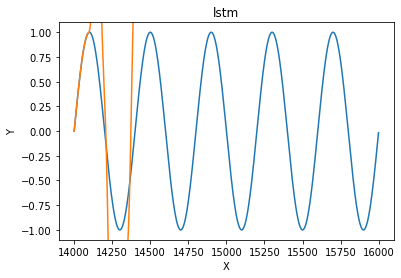

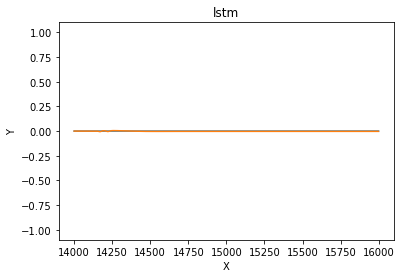

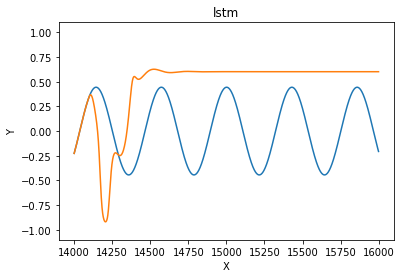

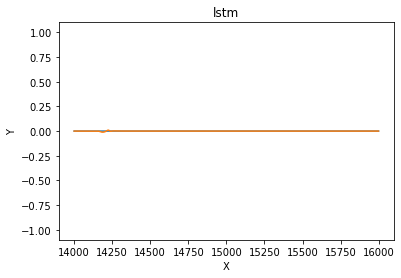

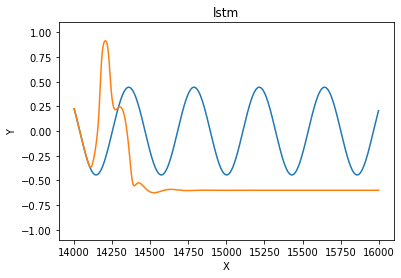

In [15]:
for particles in range(N):
    plt.plot(np.arange(tr, tr+te), qs[tr: tr + te, particles], color="tab:blue")
    plt.plot(np.arange(tr, tr+te), test_pred_lstm[:, particles], color="tab:orange")

    # Set labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("lstm")
    plt.ylim(-1.1, 1.1)

    # Show the plot
    plt.show()